In [28]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import spacy
from transformers import pipeline

sys.path.append('../scripts')

In [29]:
from Sentiment_Thematic import load_cleaned_data, sentiment_analysis, extract_keywords, assign_themes, save_data


In [30]:
cleaned_files = {
    'CBE': '../data/CBE_cleaned.csv',
    'BOA': '../data/BOA_cleaned.csv',
    'Dash': '../data/Dashen_cleaned.csv'
}

In [31]:
bank_dfs = load_cleaned_data(cleaned_files)
for bank, df in bank_dfs.items():
    print(f"\n--- Head of {bank} dataset ---")
    display(df.head(3))

Loaded CBE cleaned data: (3648, 6)
Loaded BOA cleaned data: (889, 6)
Loaded Dash cleaned data: (407, 6)

--- Head of CBE dataset ---


,review_text,rating,date,bank_name,source,bank
0,"""Why don’t your ATMs support account-to-accoun...",4,2025-06-06,CBE,Telegram,CBE
1,what is this app problem???,1,2025-06-05,CBE,Telegram,CBE
2,the app is proactive and a good connections.,5,2025-06-05,CBE,Telegram,CBE



--- Head of BOA dataset ---


,review_text,rating,date,bank_name,source,bank
0,it's not working,3,2025-06-05,BOA,Telegram,BOA
1,"Hello, I’m facing a problem with the BOA Mobil...",1,2025-06-03,BOA,Telegram,BOA
2,exceptional,5,2025-06-03,BOA,Telegram,BOA



--- Head of Dash dataset ---


,review_text,rating,date,bank_name,source,bank
0,love,3,2025-06-06,Dashen,Telegram,Dashen
1,መቸሸጠ,5,2025-06-03,Dashen,Telegram,Dashen
2,wow,5,2025-06-03,Dashen,Telegram,Dashen


In [32]:
sentiment_model = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device=-1)  # device=-1 forces CPU


Device set to use cpu


In [33]:
for bank, df in bank_dfs.items():
    print(f"Running sentiment analysis for {bank}...")
    bank_dfs[bank] = sentiment_analysis(df, model=sentiment_model)

Running sentiment analysis for CBE...
Running sentiment analysis for BOA...
Running sentiment analysis for Dash...


In [34]:
for bank, df in bank_dfs.items():
    print(f"\nTop keywords for {bank}:")
    top_keywords = extract_keywords(df)
    print([kw for kw, score in top_keywords])


Top keywords for CBE:
['good', 'app', 'good app', 'work', 'nice', 'use', 'bank', 'easy', 'application', 'cbe', 'like', 'fast', 'update', 'thank', 'transaction', 'service', 'time', 'banking', 'great', 'bad']

Top keywords for BOA:
['app', 'good', 'work', 'bad', 'bank', 'good app', 'boa', 'update', 'mobile', 'banking', 'crash', 'like', 'nice', 'time', 'use', 'bad app', 'application', 'slow', 'open', 'well']

Top keywords for Dash:
['app', 'good', 'dashen', 'bank', 'super', 'good app', 'fast', 'amazing', 'easy', 'banking', 'use', 'dashen bank', 'super app', 'wow', 'application', 'nice', 'work', 'feature', 'step', 'great']


In [35]:
themes = {
    "App Usability & Interface": ["good", "nice", "easy", "design", "ui", "super", "feature"],
    "App Performance & Reliability": ["crash", "slow", "bug", "error", "update", "hang"],
    "Banking Services": ["transaction", "transfer", "account", "balance", "loan", "deposit"],
    "Customer Support": ["help", "support", "response", "call", "agent", "service"],
    "Access Issues": ["login", "open", "register", "password", "access"]
}

In [36]:
def assign_themes(text, themes):
    assigned = []
    for theme, keywords in themes.items():
        if any(kw in text.lower() for kw in keywords):
            assigned.append(theme)
    return assigned if assigned else ["Other"]

for bank, df in bank_dfs.items():
    df["identified_themes"] = df["review_text"].apply(lambda x: assign_themes(x, themes))

In [37]:
for bank, df in bank_dfs.items():
    print(f"\nTheme distribution for {bank}:")
    theme_dist = df.explode("identified_themes").groupby("identified_themes")["sentiment_label"].value_counts()
    print(theme_dist)


Theme distribution for CBE:
identified_themes              sentiment_label
Access Issues                  NEGATIVE             84
                               POSITIVE             29
App Performance & Reliability  NEGATIVE            252
                               POSITIVE             54
App Usability & Interface      POSITIVE            700
                               NEGATIVE            197
Banking Services               NEGATIVE            319
                               POSITIVE             93
Customer Support               POSITIVE            133
                               NEGATIVE            105
Other                          POSITIVE           1193
                               NEGATIVE            928
Name: count, dtype: int64

Theme distribution for BOA:
identified_themes              sentiment_label
Access Issues                  NEGATIVE            61
                               POSITIVE             8
App Performance & Reliability  NEGATIVE           152


In [38]:
nlp = spacy.load("en_core_web_sm")

In [39]:
def preprocess_text(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(tokens)

# Example: preprocess for CBE dataset (you can do for others similarly)
df = bank_dfs['CBE']  # just working on CBE here, you can loop for others too
df["processed_review"] = df["review_text"].apply(preprocess_text)

C:\Users\HP\AppData\Local\Temp\ipykernel_11364\1160358462.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="rating", y="sentiment_score", palette="viridis")


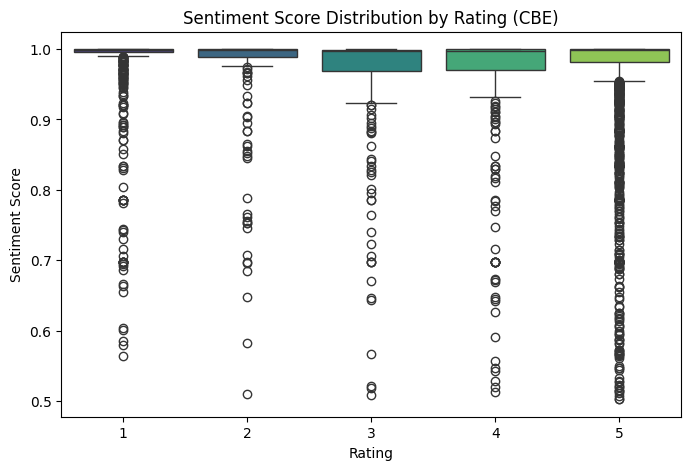

In [40]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="rating", y="sentiment_score", palette="viridis")
plt.title("Sentiment Score Distribution by Rating (CBE)")
plt.xlabel("Rating")
plt.ylabel("Sentiment Score")
plt.show()

   rating      mean  count
0       1  0.977643    666
1       2  0.964669    182
2       3  0.959157    242
3       4  0.956689    335
4       5  0.959409   2223


C:\Users\HP\AppData\Local\Temp\ipykernel_11364\3002416799.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rating_sentiment, x="rating", y="mean", palette="coolwarm")


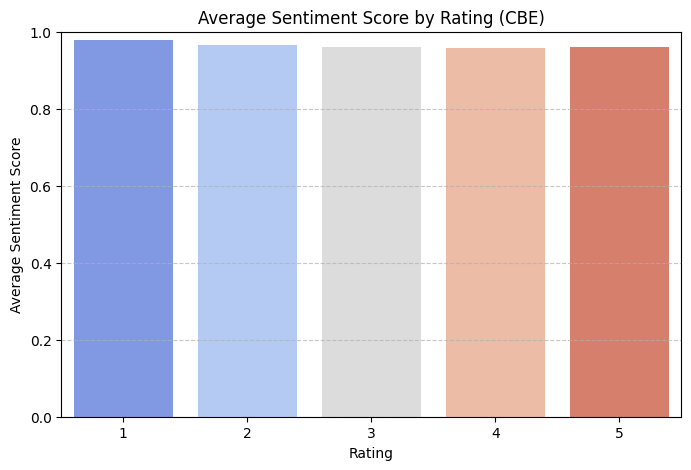

In [41]:
rating_sentiment = df.groupby("rating")["sentiment_score"].agg(['mean', 'count']).reset_index()
print(rating_sentiment)

# Step 13: Barplot of average sentiment score by rating
plt.figure(figsize=(8,5))
sns.barplot(data=rating_sentiment, x="rating", y="mean", palette="coolwarm")
plt.title("Average Sentiment Score by Rating (CBE)")
plt.xlabel("Rating")
plt.ylabel("Average Sentiment Score")
plt.ylim(0, 1)  # Adjust if sentiment score range differs
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()